#### 1번, 2번, 3번, 4번 노트북에 기재되어 있는 것은 중복을 피했습니다.

#### Actor-Critic Method (REINFORCE with Critic) 은 sutton책의 chapter 13의 13.5의 pseudo code를 참조하시면 됩니다. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

import gym
import os 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# for using sampling with gradient-tracking when selecting an action
from torch.distributions import Normal

In [2]:
class Policy(nn.Module):

    def __init__(self, input_dim, action_dim, hidden):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden)
        self.mean = nn.Linear(hidden, action_dim) 
        self.mean_scale = 2 # choose value of 2 for the pendulum env
        self.std = nn.Linear(hidden, action_dim) 
        
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        mean = torch.tanh(self.mean(out)) * self.mean_scale 
        std = torch.exp(self.std(out)) 
        return mean, std

In [3]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1) 
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = self.fc2(out)
        return out 

In [4]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, state_dim, action_dim, hidden, policy_learning_rate, critic_learning_rate, device, save_mode, model_name, saving_start_epi):
        # environment parameter
        self.gamma = gamma
        self.env = env

        # trainig parameter
        self.device = device
        self.n_epi = n_epi
        self.max_steps = max_steps
        self.plot_freq = plot_freq
        self.frame_cnt = 0

        # network paramter
        self.p_lr = policy_learning_rate
        self.c_lr = critic_learning_rate
        self.policy = Policy(state_dim, action_dim, hidden).to(self.device)
        self.critic = Critic(state_dim, action_dim, hidden).to(self.device) # 클래스 변수 이름만 base에서 critic으로 바꿔주었습니다.
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.p_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.c_lr)
        
        # log parameter
        self.avg = []
        self.scores = []
        self.p_losses = []
        self.c_losses = []
        self.save_mode = save_mode
        self.model_name = model_name
        self.saving_start = saving_start_epi
        
    def select_action(self, state):
        mean, std = self.policy(torch.FloatTensor(state).view(1, -1).to(self.device)) 
        nor_dist = Normal(mean, std) 
        action = torch.clamp(nor_dist.sample(), min=-2.0, max=2.0)
        
        return action.detach().cpu().numpy()[0], nor_dist.log_prob(action)[0].sum(), mean.detach().cpu().numpy(), std.detach().cpu().numpy()
    
    def train(self):
        
        for i_episode in range(1, self.n_epi+1):
            epi_history = []
            rewards = [] 
            score = 0
            n_step = 0
            p_loss_epi = 0
            c_loss_epi = 0

            state = self.env.reset() 
            for step in range(self.max_steps):
                action, log_prob, mean, std = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                
                loss = self._update_networks(state, next_state, reward, int(done), log_prob, n_step)
                p_loss_epi += loss[0] 
                c_loss_epi += loss[1]
                
                state = next_state
                score += reward
                n_step += 1
                self.frame_cnt += 1
                if done: break
                    
            self.scores.append(score)
            self.p_losses.append(p_loss_epi) 
            self.c_losses.append(c_loss_epi)
            if i_episode%self.plot_freq == 0:
                self._plot_status(i_episode, self.p_losses, self.c_losses, self.scores)
                
            if self.save_mode & (i_episode > self.saving_start): self._save_model()
            self.avg.append(np.mean(self.scores[-10:]))
            
    def test(self, model_path):
        
        self.policy.load_state_dict(torch.load(model_path))
        self.policy.eval()
        
        state = self.env.reset()
        done = False
        score = 0
        accum_frames = []
        while not done:
            accum_frames.append(self.env.render(mode="rgb_array"))
            action, log_prob, prob  = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return accum_frames
    
    def _update_networks(self, state, next_state, reward, done, log_prob, n_step):
        critic_value = self.critic(torch.FloatTensor(state).unsqueeze(0).to(device)) 
        target_value = reward + (1-done)*self.gamma*self.critic(torch.FloatTensor(next_state).unsqueeze(0).to(device)) 
        delta = (target_value - critic_value).detach() 
        
        p_loss = -log_prob * delta * (self.gamma**n_step)
        c_loss = -critic_value * delta
        
        self.policy_optimizer.zero_grad() 
        p_loss.backward() 
        self.policy_optimizer.step() 

        self.critic_optimizer.zero_grad() 
        c_loss.backward() 
        self.critic_optimizer.step() 
        
        return [p_loss.item(), c_loss.item()] 
    
    def _save_model(self):
        last_mean = np.mean(self.scores[-10:])
        if  max(self.avg) < last_mean:
            torch.save(self.policy.state_dict(), self.model_name+f'Score_{round(last_mean, 3)}.pt')
    
    def _plot_status(self, i_episode, p_losses, c_losses, score_hist):
        subplot_params = [
            (311, f"Scores in episode_{i_episode}", score_hist),
            (312, f"Policy loss in episode:{i_episode}", p_losses),
            (313, f"Critic loss in episode:{i_episode}", c_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(20, 20), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show()

In [5]:
device = torch.device(
            "cuda:1" if torch.cuda.is_available() else "cpu"
        )

env_list = ["Pendulum-v0", "MountainCarContinuous-v0", "LunarLanderContinuous-v2"]
env_name = env_list[2]
env = gym.make(env_name)

saving_start_epi = 100

save_mode = False
model_save_folder = './model_save'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
model_name = f"./{model_save_folder}/Discrete_Actor_Critic_{env_name}_"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

n_epi = 100000 
max_steps = 1000
gamma = 0.98
plot_freq = 10

hidden = 64 
P_learning_rate = 0.00015
C_learning_rate = 0.0015

Environment:  LunarLanderContinuous-v2
State Dimension: 8  Action Dimension: 2


In [6]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            P_learning_rate,
            C_learning_rate,
            device, save_mode,
            model_name,
            saving_start_epi)

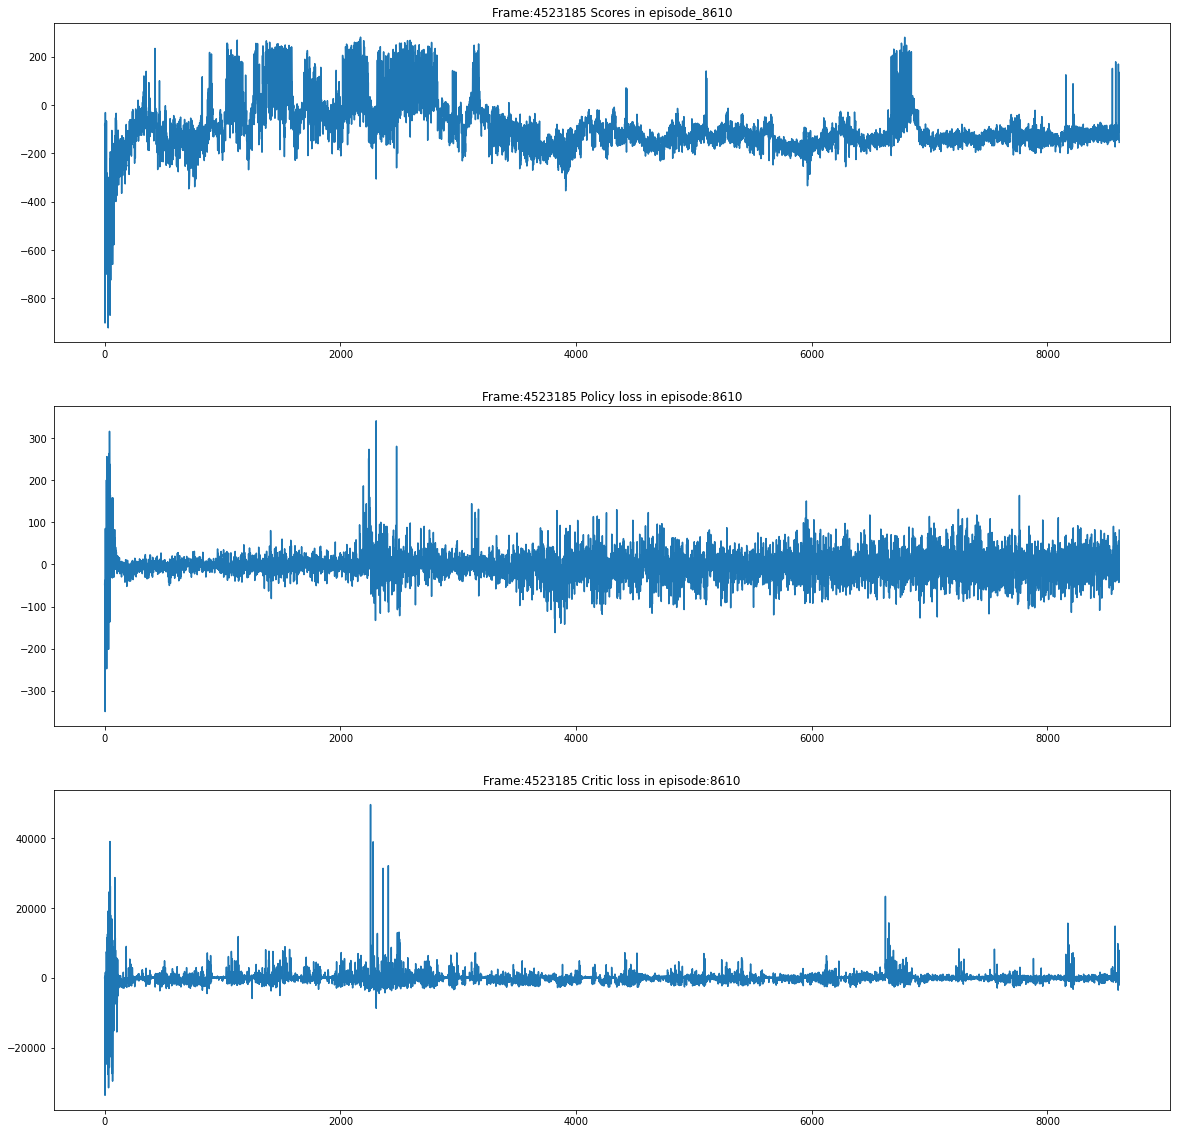

In [ ]:
agent.train() 

In [ ]:
model_path = f"{model_name}...."
frames = agent.test(model_path)

import imageio
from IPython.display import Video
imageio.mimwrite('./test1.mp4', frames, fps=30)
Video('./test1.mp4', width=480, height=360)

    LunarLander-v0

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.95
    plot_freq = 10

    hidden = 128 
    P_learning_rate = 0.0001
    C_learning_rate = 0.001

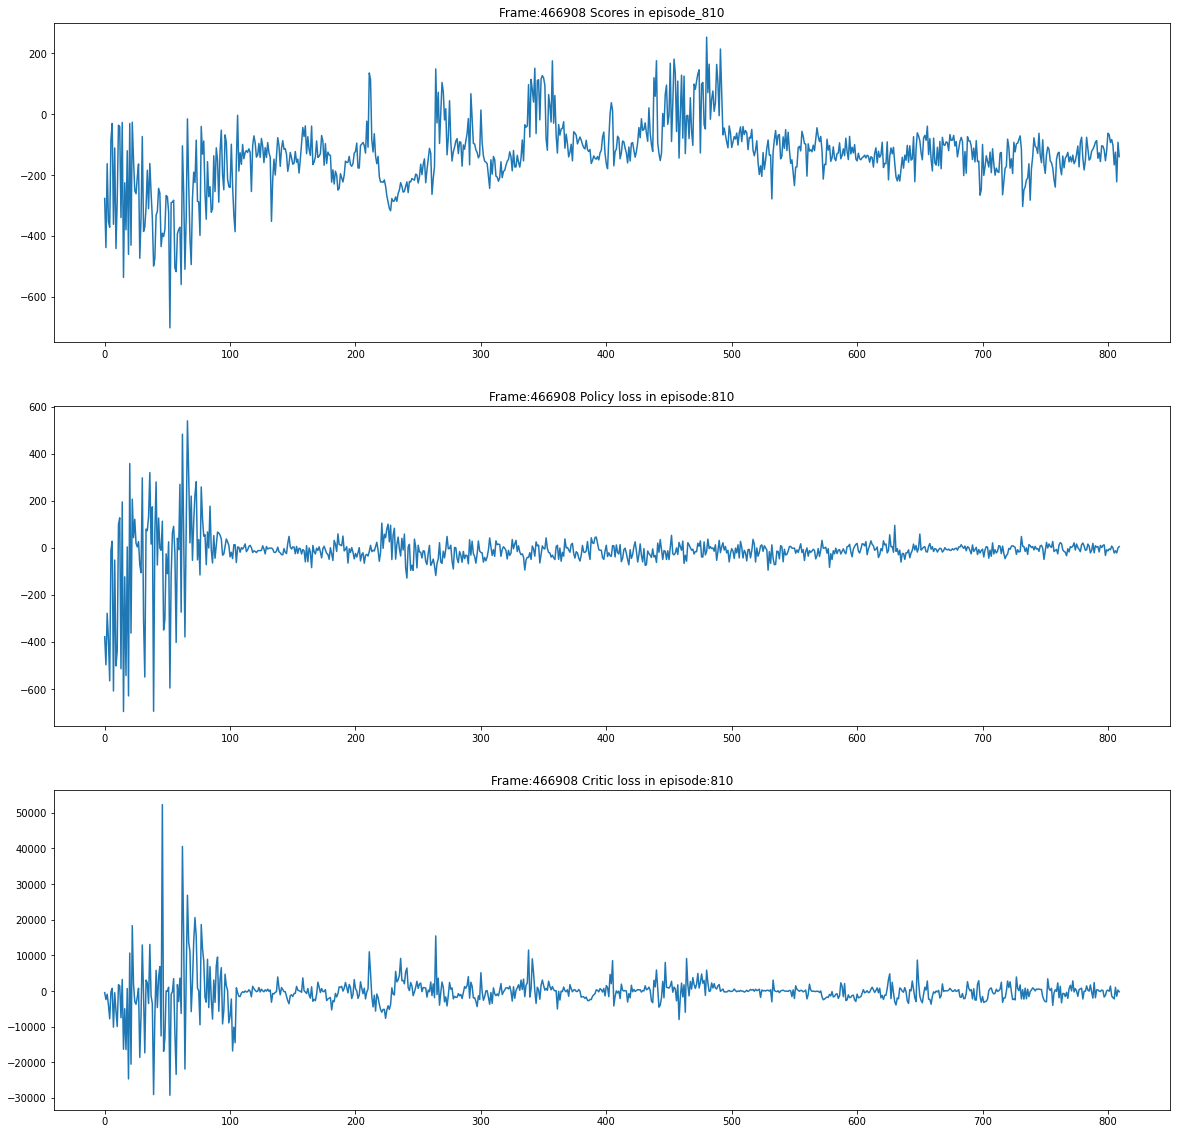

    LunarLander-v0
    
    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 128 
    P_learning_rate = 0.0001
    C_learning_rate = 0.001

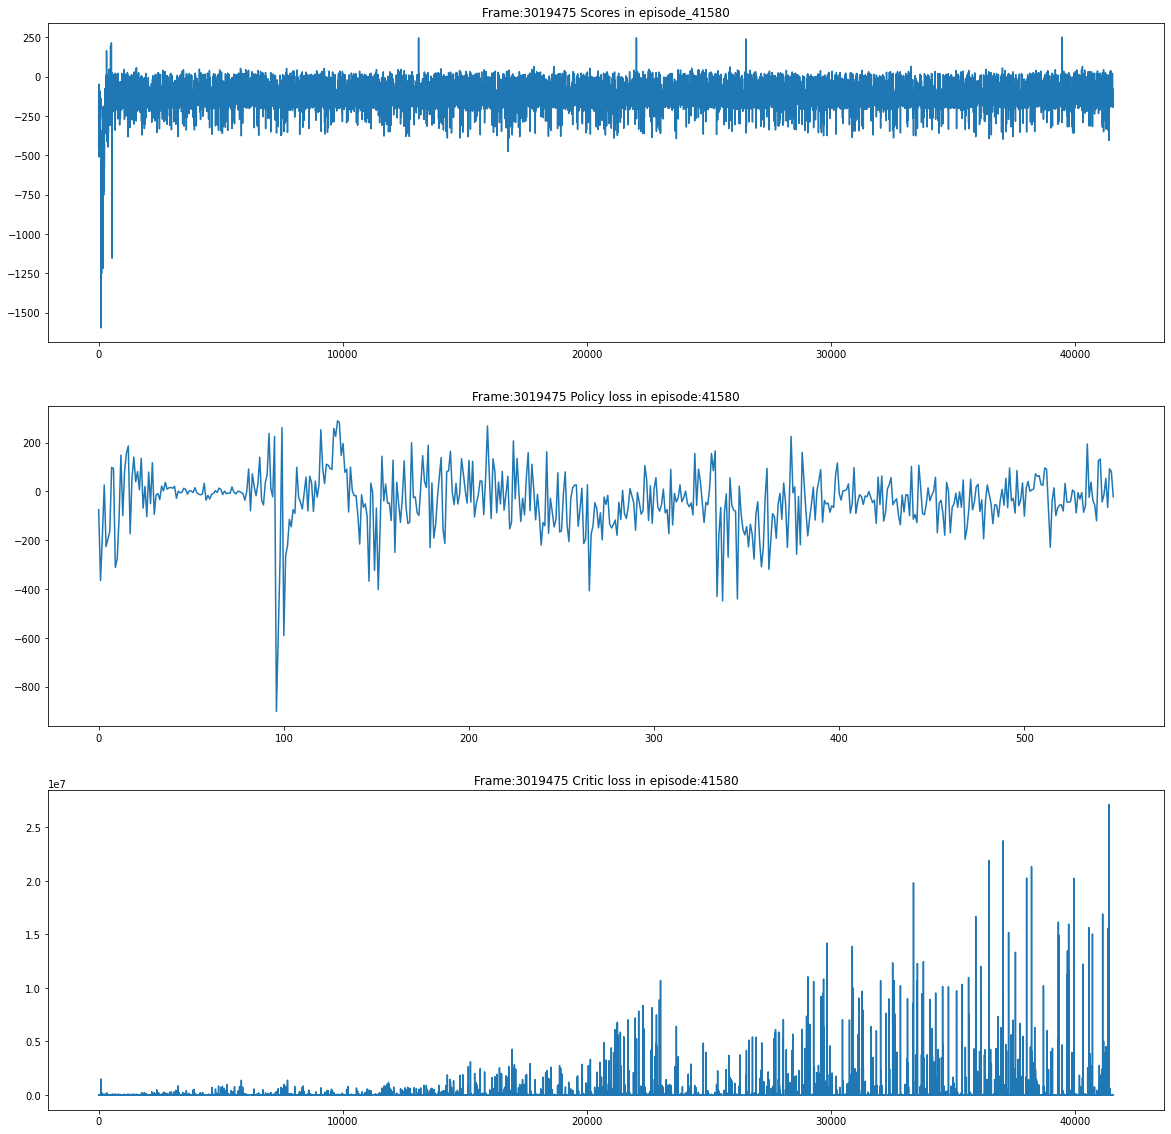

#### 하단의 그래프는 모두 CartPole 환경에서의 결과입니다. hyperparameter에 따라 결과가 많이 다르다는 것을 확인할 수 있습니다.
#### 그리고 REINFORCE보다 학습이 더 빨리 되지 않다는 것을 보실 수 있는데요, 최적 hyper parameter를 찾기가 쉽지 않았습니다. 

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 32
    policy_learning_rate = 0.0001
    critic_learning_rate = 0.003

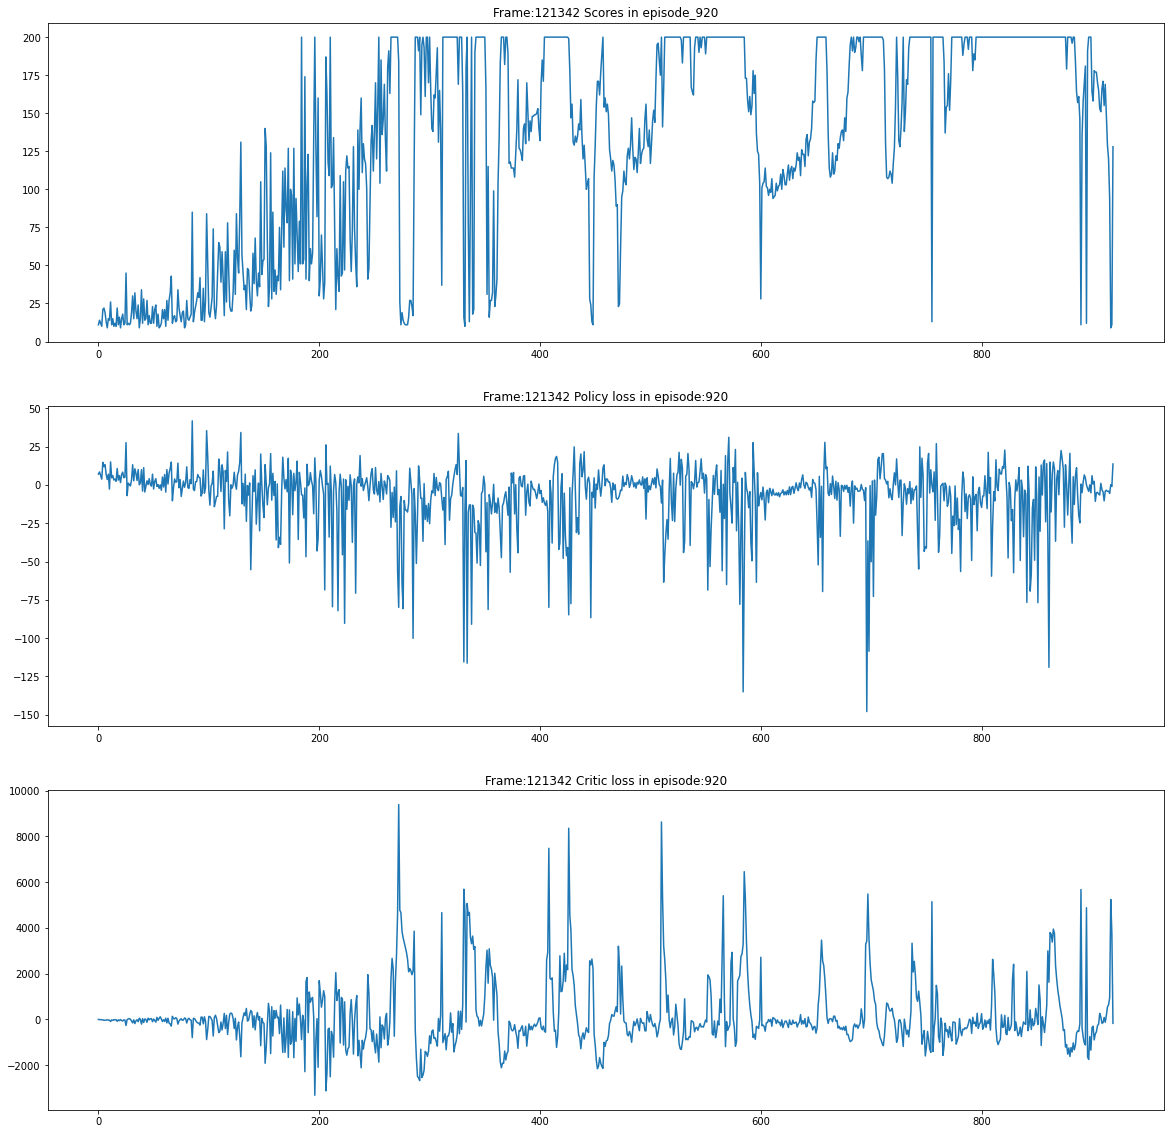

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 128
    policy_learning_rate = 0.001
    critic_learning_rate = 0.01

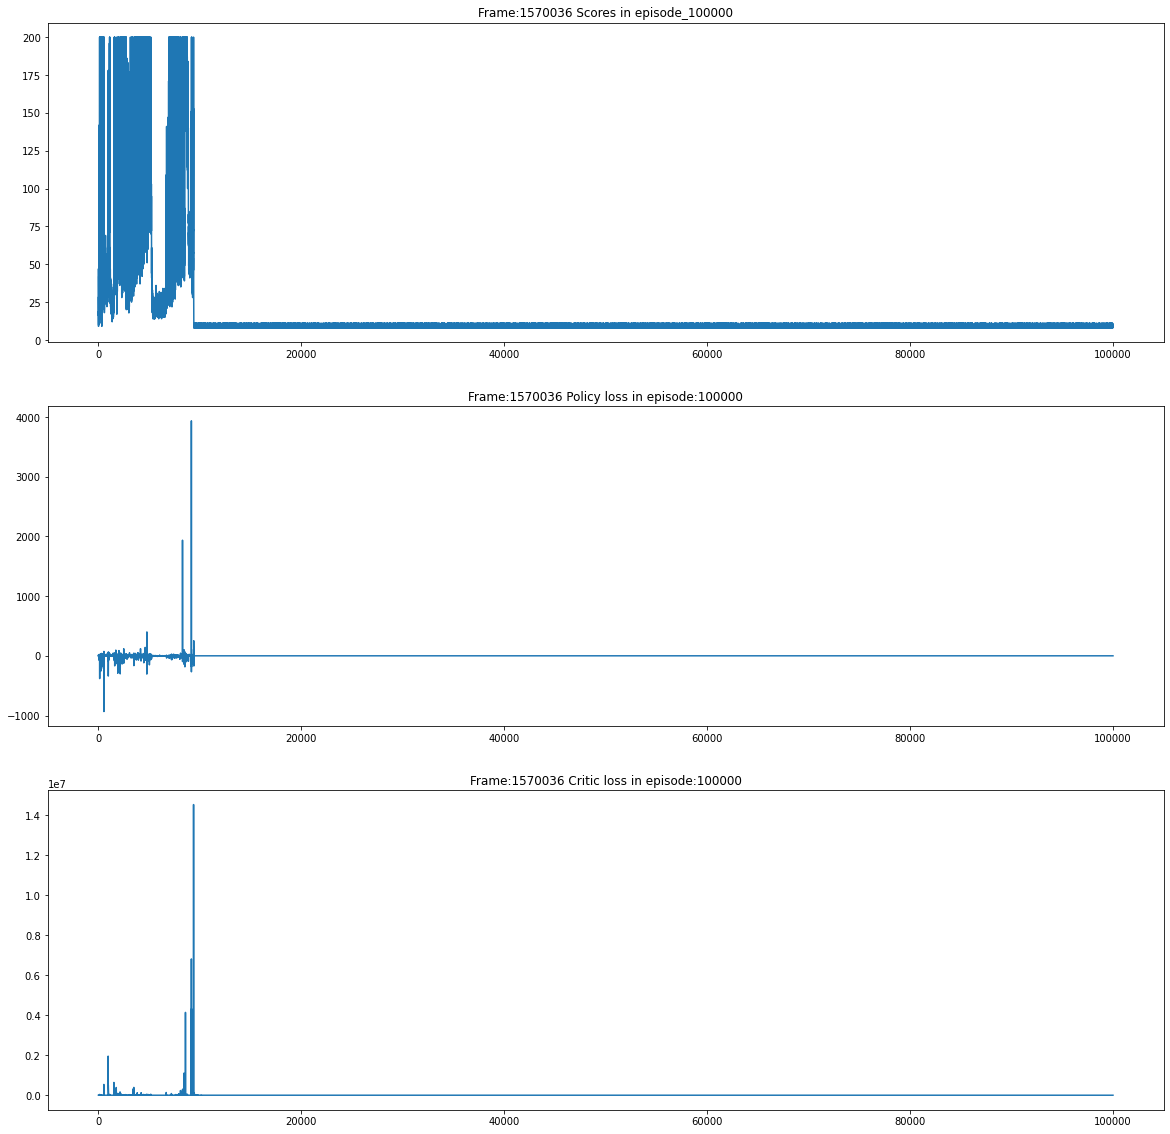

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 128
    policy_learning_rate = 0.0001
    critic_learning_rate = 0.0001

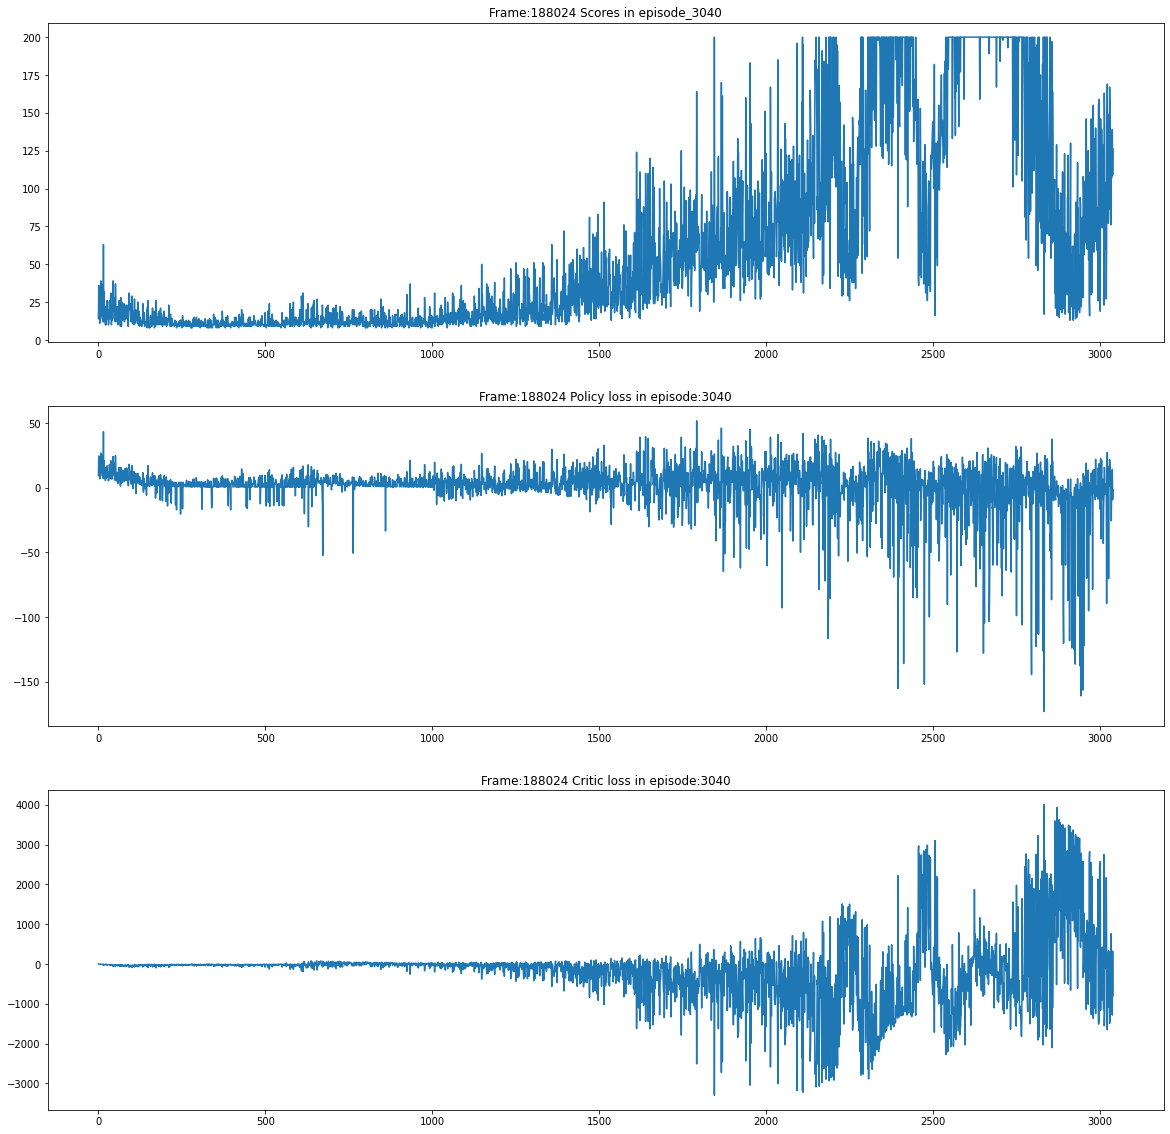

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 64
    policy_learning_rate = 0.0001
    critic_learning_rate = 0.001

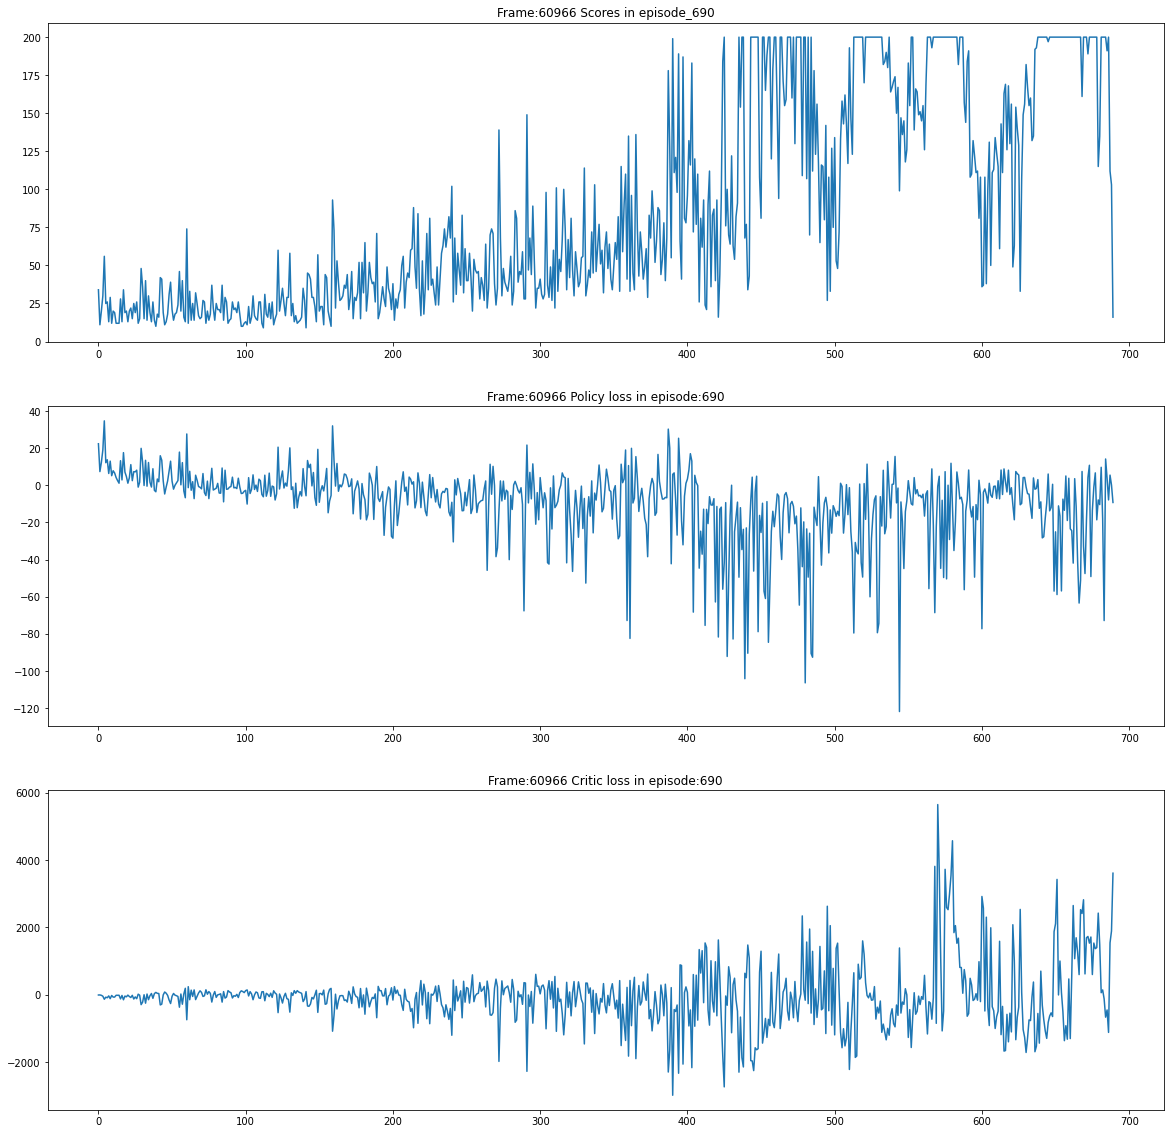